This script computes nFR for each cluster based on the tree and test the difference of nFR in each clsuter between disease and health group.


In [1]:
# This script computes nFR for each cluster based on the tree
# and test the difference of nFR in each clsuter between disease and health group
import sys
sys.path.append('../src')
import abd_profile
import os
import pandas as pd
import GCN
import copy
import numpy as np
import tree_util
from scipy.stats import mannwhitneyu
import seaborn as sns 
import matplotlib.pyplot as plt
import matplotlib as mpl
import json
from statsmodels.stats.multitest import fdrcorrection as fdr

In [2]:
# Load GCN2008, distance and tree newick string
outdir = '../result/large_scale_cohort'
if not os.path.exists(outdir):
    os.makedirs(outdir)
ori_GCN = GCN.input_GCN('../data/gcn2008.tsv', transfer=True)
d_df = pd.read_csv('../data/sp_d.tsv', sep='\t', header=0, index_col=0)
with open('../result/GCN_fix_tree/renamed_GCN_tree.newick') as fp:
    newick_tree = fp.read()

In [3]:
# recover the tree from newick string
json_tree = tree_util.parse(newick_tree)
largest = {'largest': 0}
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
largest_level = largest['largest']
nlayer = largest_level
leaf_list, l = tree_util.recu_compute(json_tree, 0, largest)
layer_leaves_dict = tree_util.make_layer_dict(nlayer)

tree_util.recu_layer(json_tree, layer_leaves_dict)
tree_util.to_layer_leaves(layer_leaves_dict, nlayer)
name_dict = {}
for sp in d_df.columns:
        name_dict[sp] = sp.replace('_', '-')
renamed_GCN = ori_GCN[list(d_df.columns)].rename(columns=name_dict)
renamed_d = d_df.rename(columns=name_dict, index=name_dict)
result = {}
# compute leaf layer
result['leaves_dict'] = copy.deepcopy(layer_leaves_dict)
parent_dict = {}
tree_util.parents(json_tree, parent_dict)
node_leaves = {}
for level in layer_leaves_dict.keys():
    for node, sp_list in layer_leaves_dict[level].items():
        if node in node_leaves.keys():
            continue
        node_leaves[node] = copy.deepcopy(sp_list)
subtree_nodes = {}
for l in leaf_list:
    parent = parent_dict[l]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent].append(l)

for node in node_leaves.keys():
    parent = parent_dict[node]
    if parent not in subtree_nodes.keys():
        subtree_nodes[parent] = []
    subtree_nodes[parent] += subtree_nodes[node]
    subtree_nodes[parent].append(node)

for node in subtree_nodes.keys():
    subtree_nodes[node].append(node)

direct_children_dict = {}
for node, parent in parent_dict.items():
    if parent not in direct_children_dict:
        direct_children_dict[parent] = []
    direct_children_dict[parent].append(node)

# with open(os.path.join(outer, 'cluster_leaves.json'), 'w') as fp:
#     json.dump(node_leaves, fp)

In [4]:
result['leaves_dict']['root'] = {'root': list(name_dict.values())}
node_leaves['root'] = list(name_dict.values())

In [5]:
# compute nFR for each sample
def nfr(d_df, profile, sname):
    sp_list = list(profile.columns)
    n = len(sp_list)
    corr = np.ones(shape=(n, n)) - d_df.loc[sp_list, sp_list].values
    np.fill_diagonal(corr, 0)
    a = np.array(profile.loc[sname, sp_list])
    inter_matrix = np.dot(a.reshape(len(a), 1),a.reshape(1, len(a)))
    np.fill_diagonal(inter_matrix, 0)
    td = np.sum(inter_matrix)/2
    fr = np.sum(np.multiply(inter_matrix, corr))/2
    if td == 0:
        return 0
    return fr/td
    #return fr



In [6]:
# load profile and metadata
# compute nFR for each cluster
def main(indir, GCN_df, sp_d, result, name_dict):
    #input dir: including metadata.tsv and abd.tsv
    # output result to dir
    abd_path = os.path.join(indir, 'abd.tsv')
    metadata_path = os.path.join(indir, 'metadata.tsv')

    

    # first process data from gutmeta
    raw_profile = abd_profile.input_profile(abd_path, transfer=True)
    metadata = pd.read_csv(metadata_path, sep='\t', header=0)
    selected_raw_profile = raw_profile.loc[list(metadata['sample_id']), :]
    crc_profile = abd_profile.check(selected_raw_profile, GCN_df, name_dict)

    # classify according to the metadata
    pheno_list = {}
    pheno_profiles = {}
    for i in range(metadata.shape[0]):
        pheno = metadata.loc[i, 'disease']
        if pheno not in pheno_list.keys():
            pheno_list[pheno] = []
        if metadata.loc[i, 'sample_id'] in list(crc_profile.index):
            pheno_list[pheno].append(metadata.loc[i, 'sample_id'])

    for c, clist in pheno_list.items():
        pheno_profiles[c] = copy.deepcopy(crc_profile.loc[clist, :])
    # seperate by enterotypes
    
    level_fr_result = {}   
    for p, profile in pheno_profiles.items():
        for level, cluster_sp_dict in result['leaves_dict'].items():
            if level not in level_fr_result.keys():
                level_fr_result[level] = {}
            node_nfr = pd.DataFrame(index=profile.index)
            for node, sp_list in cluster_sp_dict.items():
                sp_list = list(set(sp_list).intersection(set(profile.columns)))
                selected_d = sp_d.loc[sp_list, sp_list]
                selected_profile = profile.loc[:, sp_list]
                
                for sname in profile.index:
                    node_nfr.loc[sname, node] = nfr(selected_d, selected_profile, sname)
            level_fr_result[level][p] = copy.deepcopy(node_nfr)
                

    return level_fr_result

 

In [7]:
fr_result = {}
plist = ['ACVD',
 'BD',
 'CRC',
 'IBD',
 'IGT',
 'CFS',
 'STH',
 'T2D',
 'adenoma',
 'asthma',
 'carcinoma_surgery_history',
 'hypertension',
 'migraine',
 'schizofrenia']
outer = '../data'
param = 0.5
for project in plist:
    projects_dir = os.path.join(outer, project)
    fr_result[project] = {}
    for dir in os.listdir(projects_dir):
        indir = os.path.join(projects_dir, dir)
        level_b = main(indir, renamed_GCN, renamed_d, result, name_dict)
        fr_result[project][dir] = copy.deepcopy(level_b)

Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Candida_tropicalis', 's__Saccharomyces_cerevisiae', 's__Candida_albicans'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Saccharomyces_cerevisiae'}
!!!species are deleted
Species not in GCN2008: {'s__Blastocystis_sp_subtype_1', 's__Malassezia_restric

In [8]:
# output nfr to file
def output_fr(fr_result, outdir, pheno, project):
    odir = os.path.join(outdir, pheno, project, 'nFR')
    if not os.path.exists(odir):
        os.makedirs(odir)
    pheno_df = pd.DataFrame()
    for level, level_result in fr_result[pheno][project].items():
        pheno_result = level_result[pheno]
        for node in pheno_result.columns:
            if node not in pheno_df.columns:
                for sname in pheno_result.index:
                    pheno_df.loc[sname, node] = pheno_result.loc[sname, node]
    pheno_df.to_csv(os.path.join(odir, 'fr_{}.tsv'.format(pheno)), sep='\t')
    health_df = pd.DataFrame()
    for level, level_result in fr_result[pheno][project].items():
        pheno_result = level_result['Health']
        for node in pheno_result.columns:
            if node not in health_df.columns:
                for sname in pheno_result.index:
                    health_df.loc[sname, node] = pheno_result.loc[sname, node]
    health_df.to_csv(os.path.join(odir, 'fr_{}.tsv'.format('Health')), sep='\t')

In [9]:
for pheno in fr_result.keys():
    for project in fr_result[pheno].keys():
        output_fr(fr_result, outdir, pheno, project)

In [10]:
mpl.rcParams['figure.dpi'] = 300
p_cutoff = 0.05

p_df = pd.DataFrame()
mean_df = pd.DataFrame()
valid_dict = {}
show_node = []
for level in result['leaves_dict'].keys():
    cohort_list = []
    for project in plist:
        for dir in fr_result[project].keys():
            
            if project not in fr_result[project][dir][level].keys():
                continue
            if 'Health' not in fr_result[project][dir][level].keys():
                continue
            if dir not in valid_dict.keys():
                valid_dict[dir] = []
            l_fr1 = fr_result[project][dir][level][project]
            l_fr2 = fr_result[project][dir][level]['Health']
            for inode in l_fr1.columns:
                if (list(l_fr1[inode]).count(0) > len(list(l_fr1[inode]))*0.8) and (list(l_fr2[inode]).count(0) > len(list(l_fr2[inode]))*0.8):
                    continue
                valid_dict[dir].append(inode)
                #t, p1 = ttest_ind(list(l_fr1[inode]), list(l_fr2[inode]), equal_var=False)
                t, p1 = mannwhitneyu(list(l_fr1[inode]), list(l_fr2[inode]))
                p_df.loc[dir, inode] = p1
                mean_df.loc[dir, inode] = np.mean(l_fr1[inode]) - np.mean(l_fr2[inode])
p_df.fillna(np.nan, inplace=True)

In [11]:
# FDR adjust
for dir in p_df.index:
    valid_nodes = valid_dict[dir]
    p_vector = list(p_df.loc[dir, valid_nodes])
    p_adj = fdr(p_vector, p_cutoff)[1]
    for i, node in enumerate(valid_nodes):
        p_df.loc[dir, node] = p_adj[i]
p_df.to_csv(os.path.join(outdir, 'p_all_cohorts_nfr.tsv'), sep='\t')

In [12]:
node_plot = pd.DataFrame()
for dir in p_df.index:
    for inode in p_df.columns:
        p1 = p_df.loc[dir, inode]
        if pd.isna(p1):
            node_plot.loc[dir, inode] = np.nan
        elif p1 < p_cutoff:
            if mean_df.loc[dir, inode] > 0:
                node_plot.loc[dir, inode] = 1
            else:
                node_plot.loc[dir, inode] = -1
        else:
            node_plot.loc[dir, inode] = 0



In [13]:
# plot the result of differential test
show_node = []
for inode in node_plot.columns:
    all_zero = True
    all_nan = True
    for dir in node_plot.index:
        if not pd.isna(node_plot.loc[dir, inode]):
            all_nan = False
        if node_plot.loc[dir, inode] != 0:
            all_zero = False
    if not (all_zero or all_nan):
        show_node.append(inode)
plt.figure(figsize=(10, 6))
part_df = node_plot[show_node]
cluster_name_dict = {}
for inode in part_df.columns:
    cluster_name_dict[inode] = inode.split('_')
    if len(cluster_name_dict[inode])>1:
        cluster_name_dict[inode] = cluster_name_dict[inode][1]
    else:
        cluster_name_dict[inode] = cluster_name_dict[inode][0]
part_df.rename(columns=cluster_name_dict, inplace=True)
sns.heatmap(part_df, vmax=1, vmin=-1, square=True, linecolor='black', cbar=False, xticklabels=True, yticklabels=True, linewidths=1, cmap="coolwarm")
plt.title('Different nFR of all cohorts')
plt.xticks(rotation=90)
ax = plt.gca()

ax.spines['top'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['left'].set_visible(True)
ax.spines['right'].set_visible(True)
opath = os.path.join(outdir, 'all_cohorts_nfr.svg')
plt.tight_layout()
plt.savefig(opath, dpi=300, format='svg')

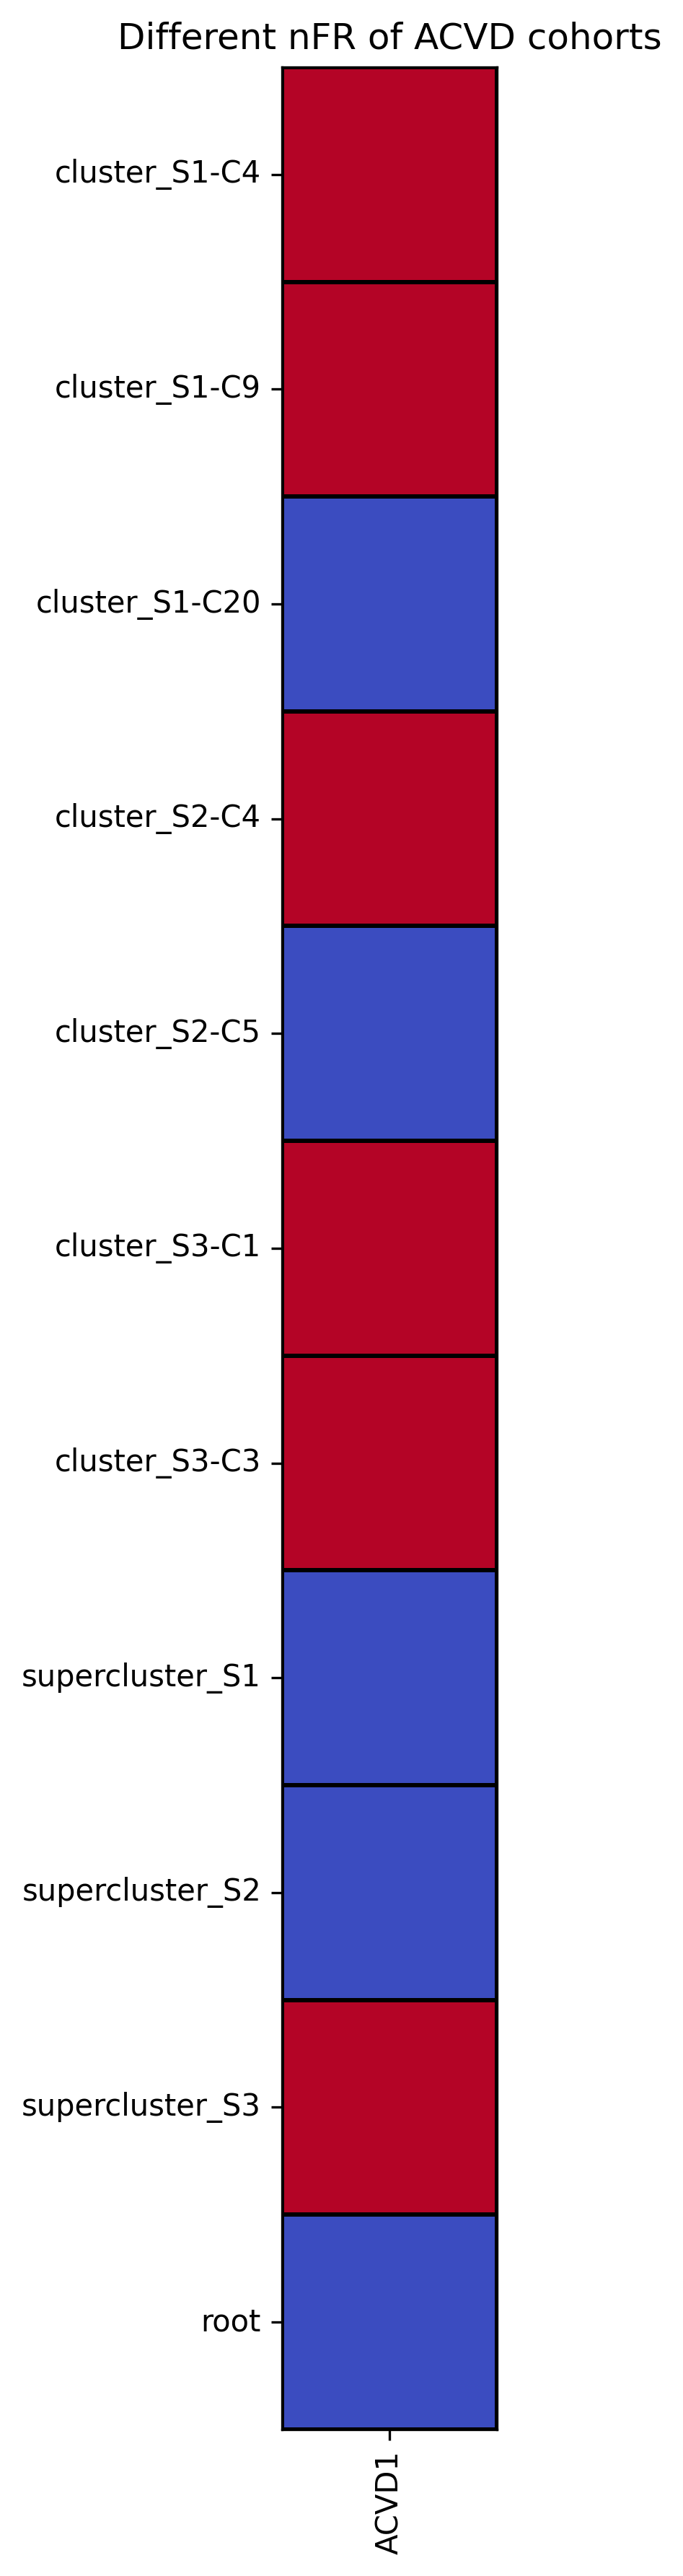

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


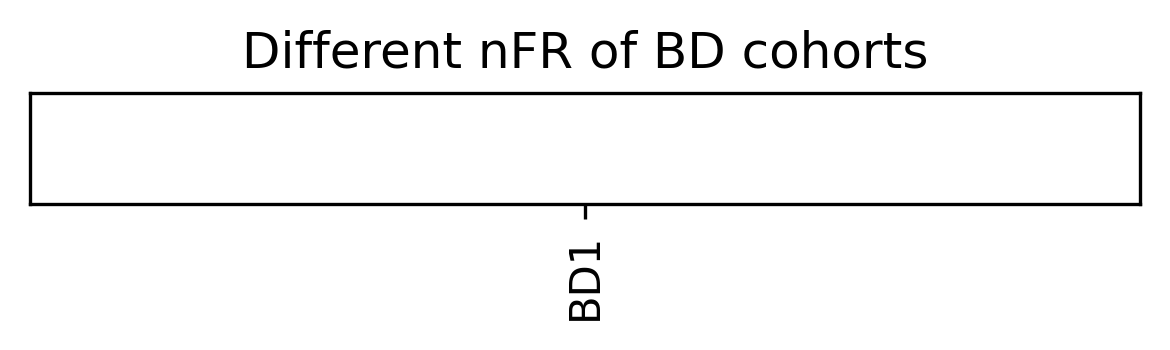

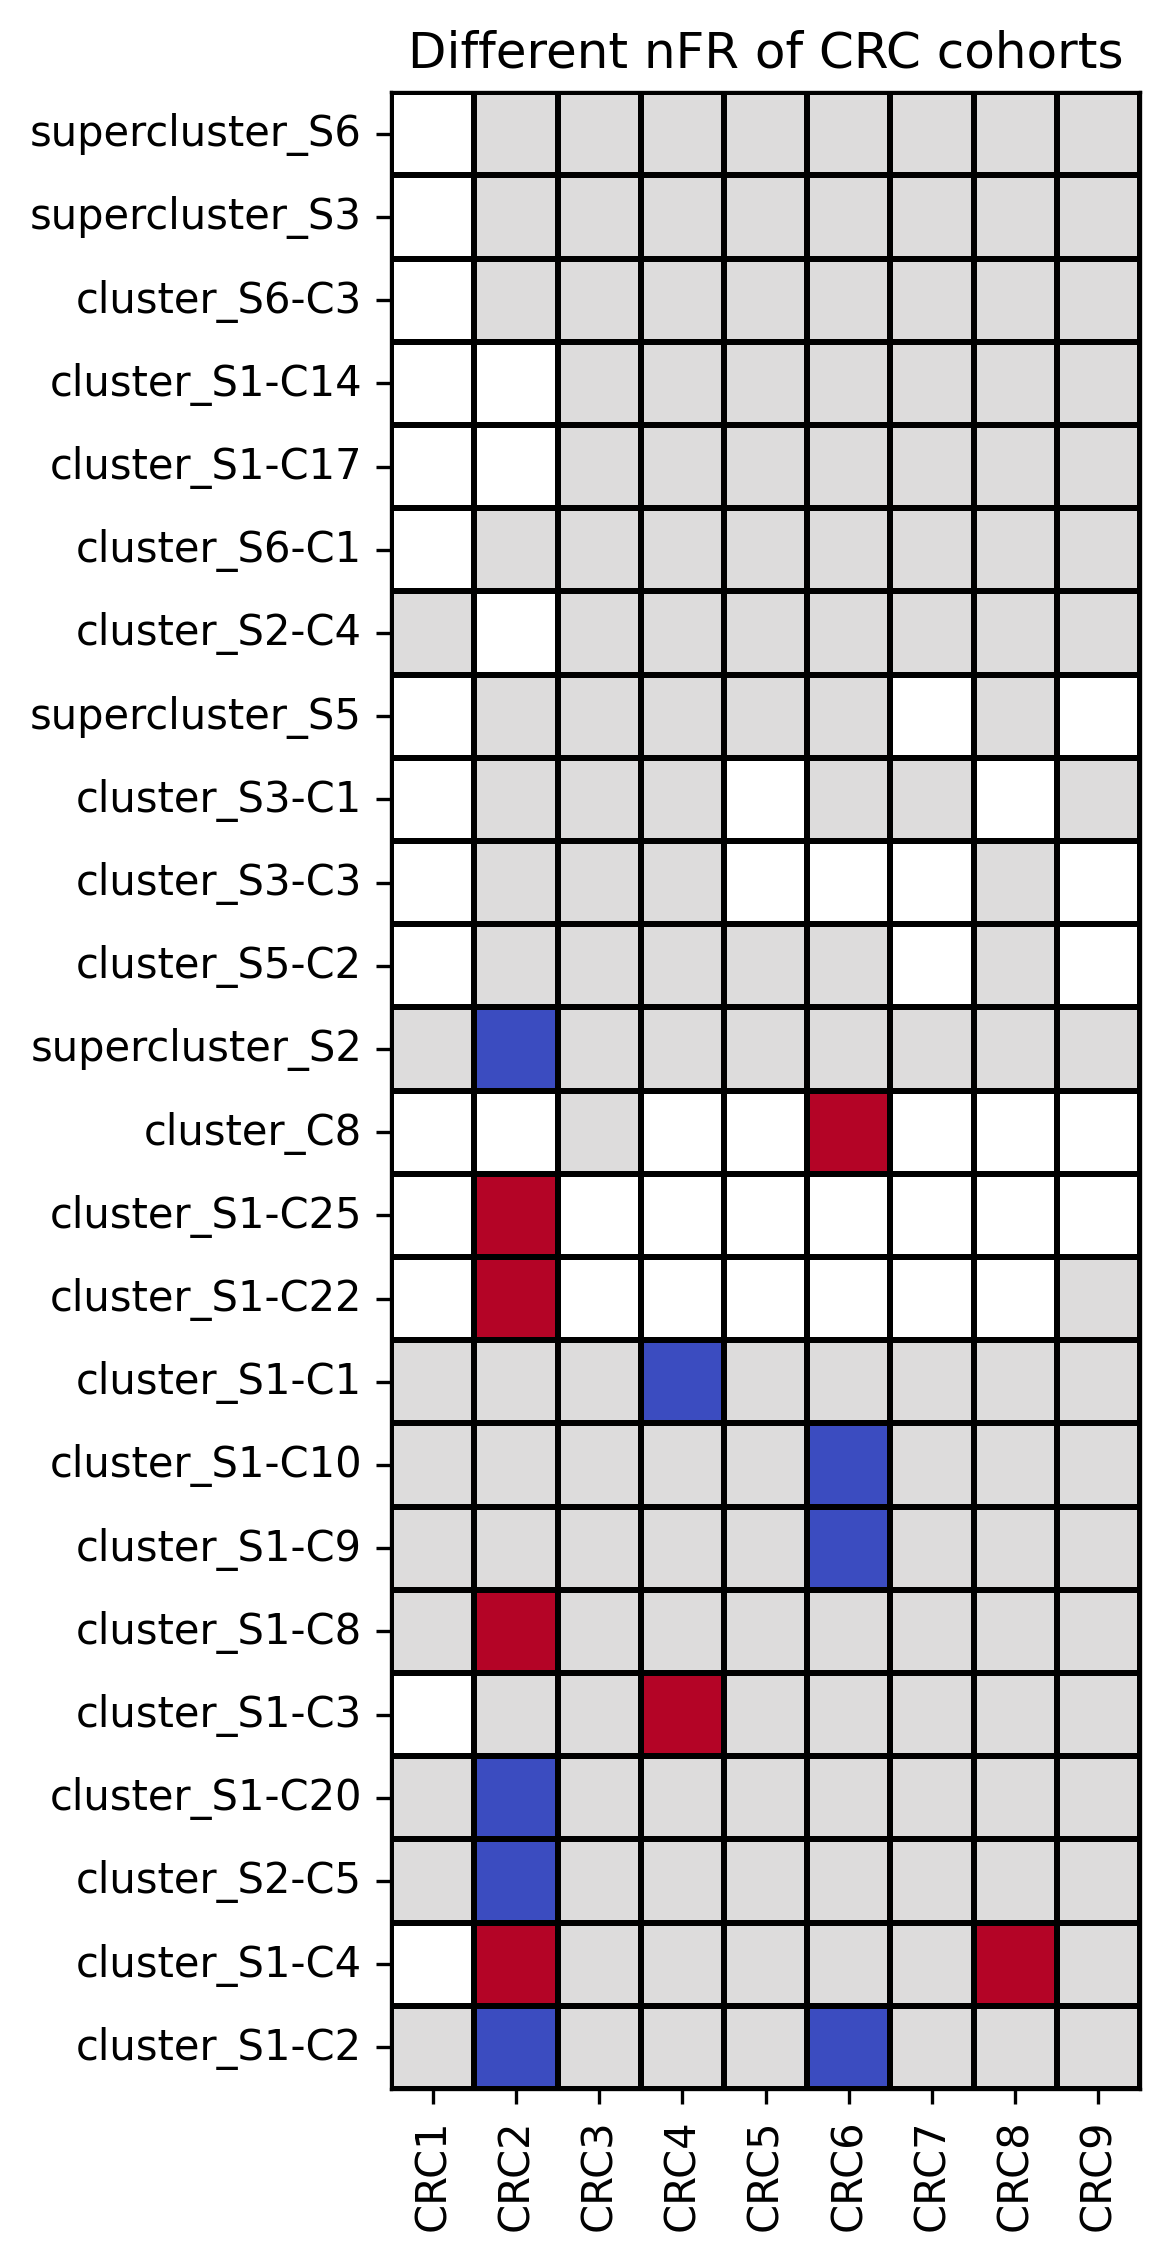

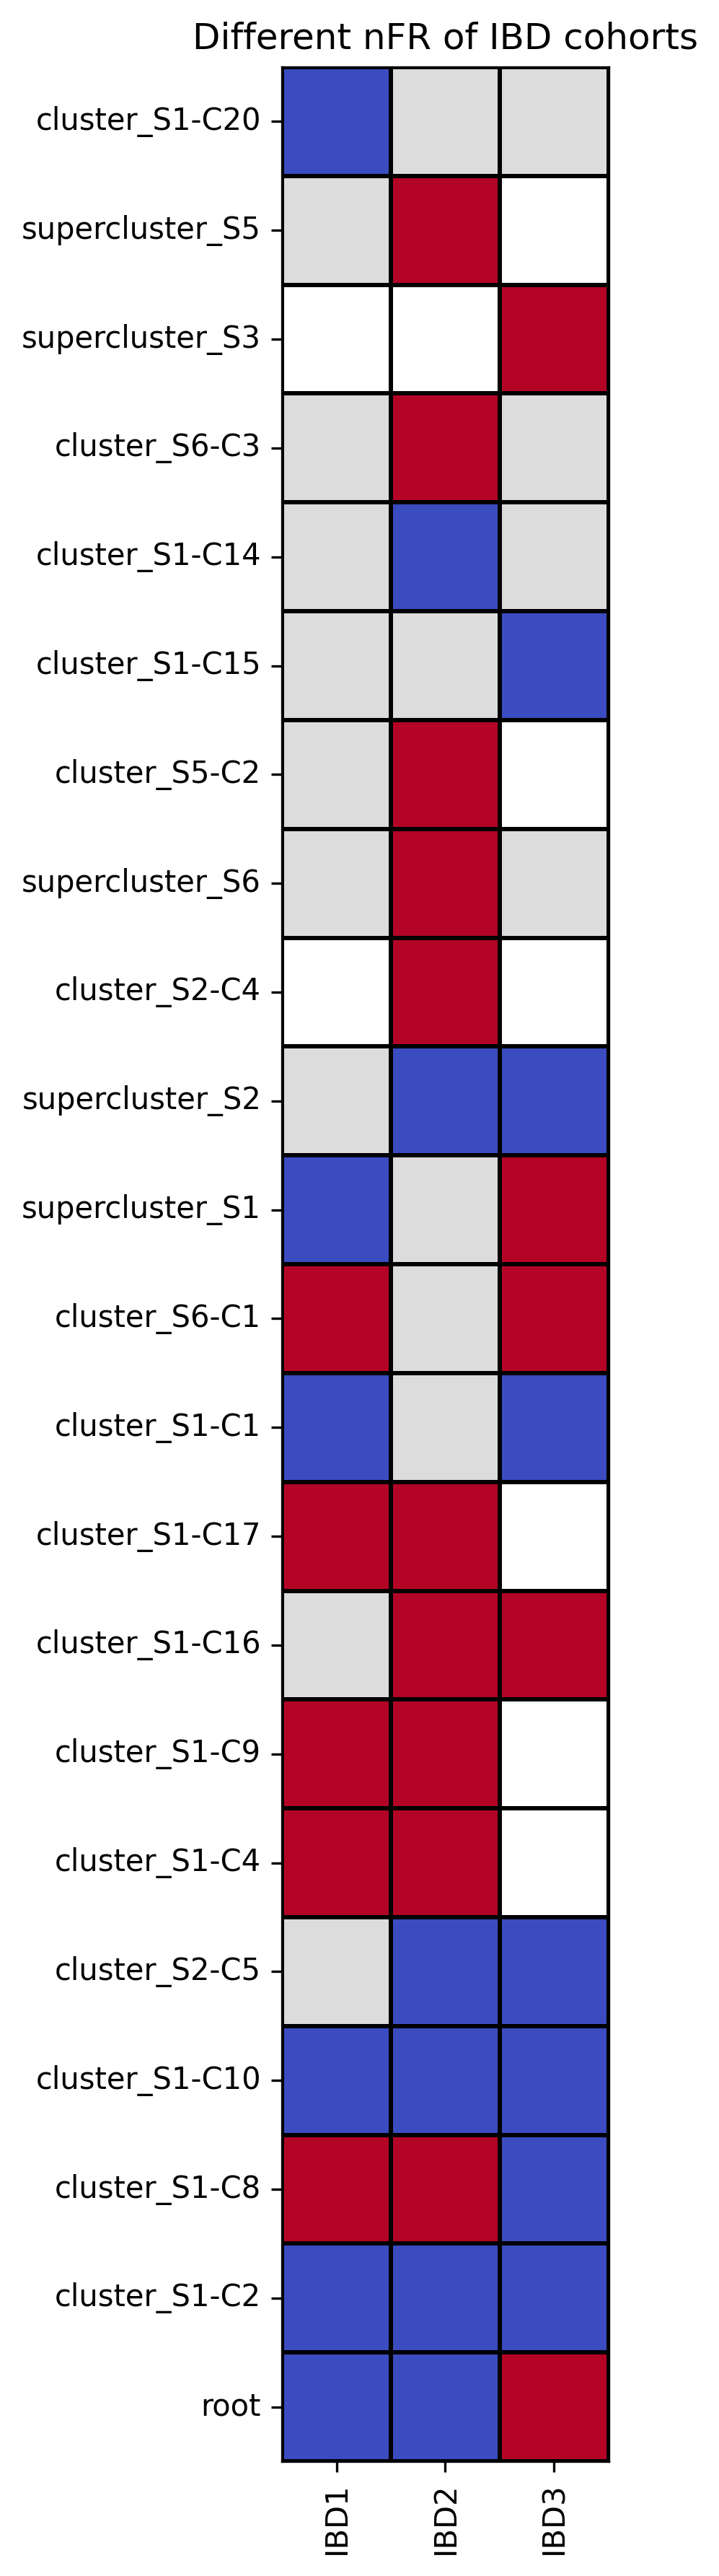

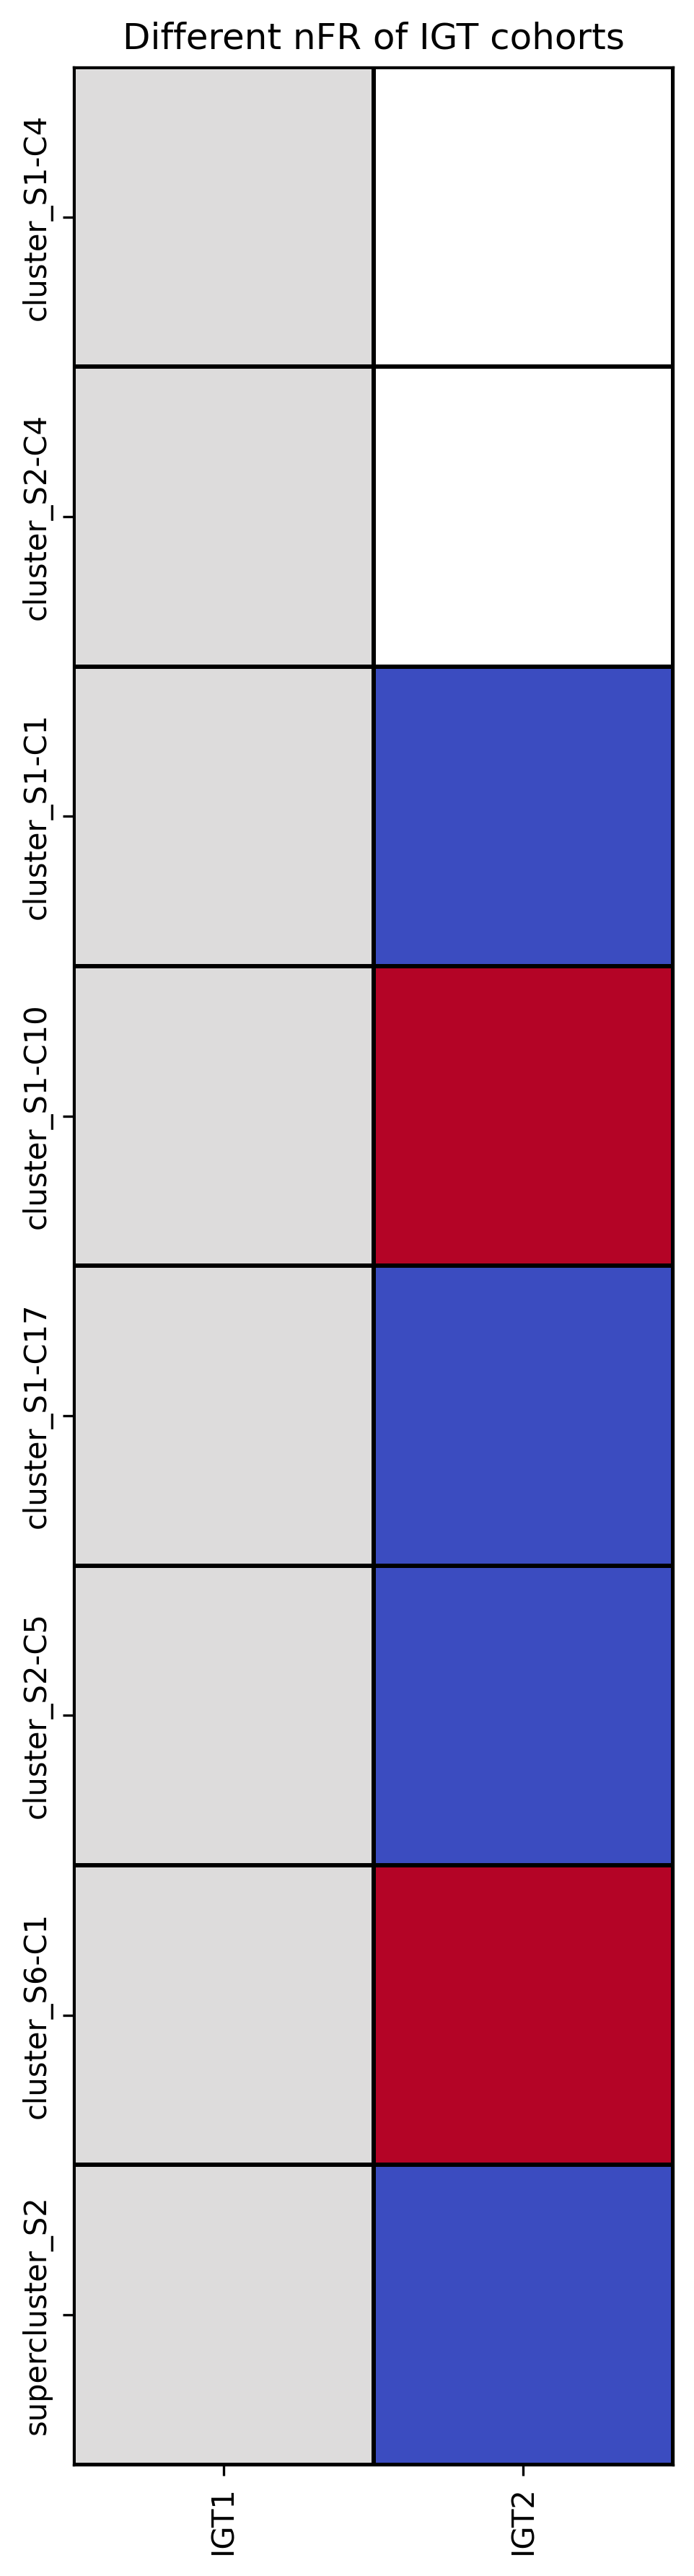

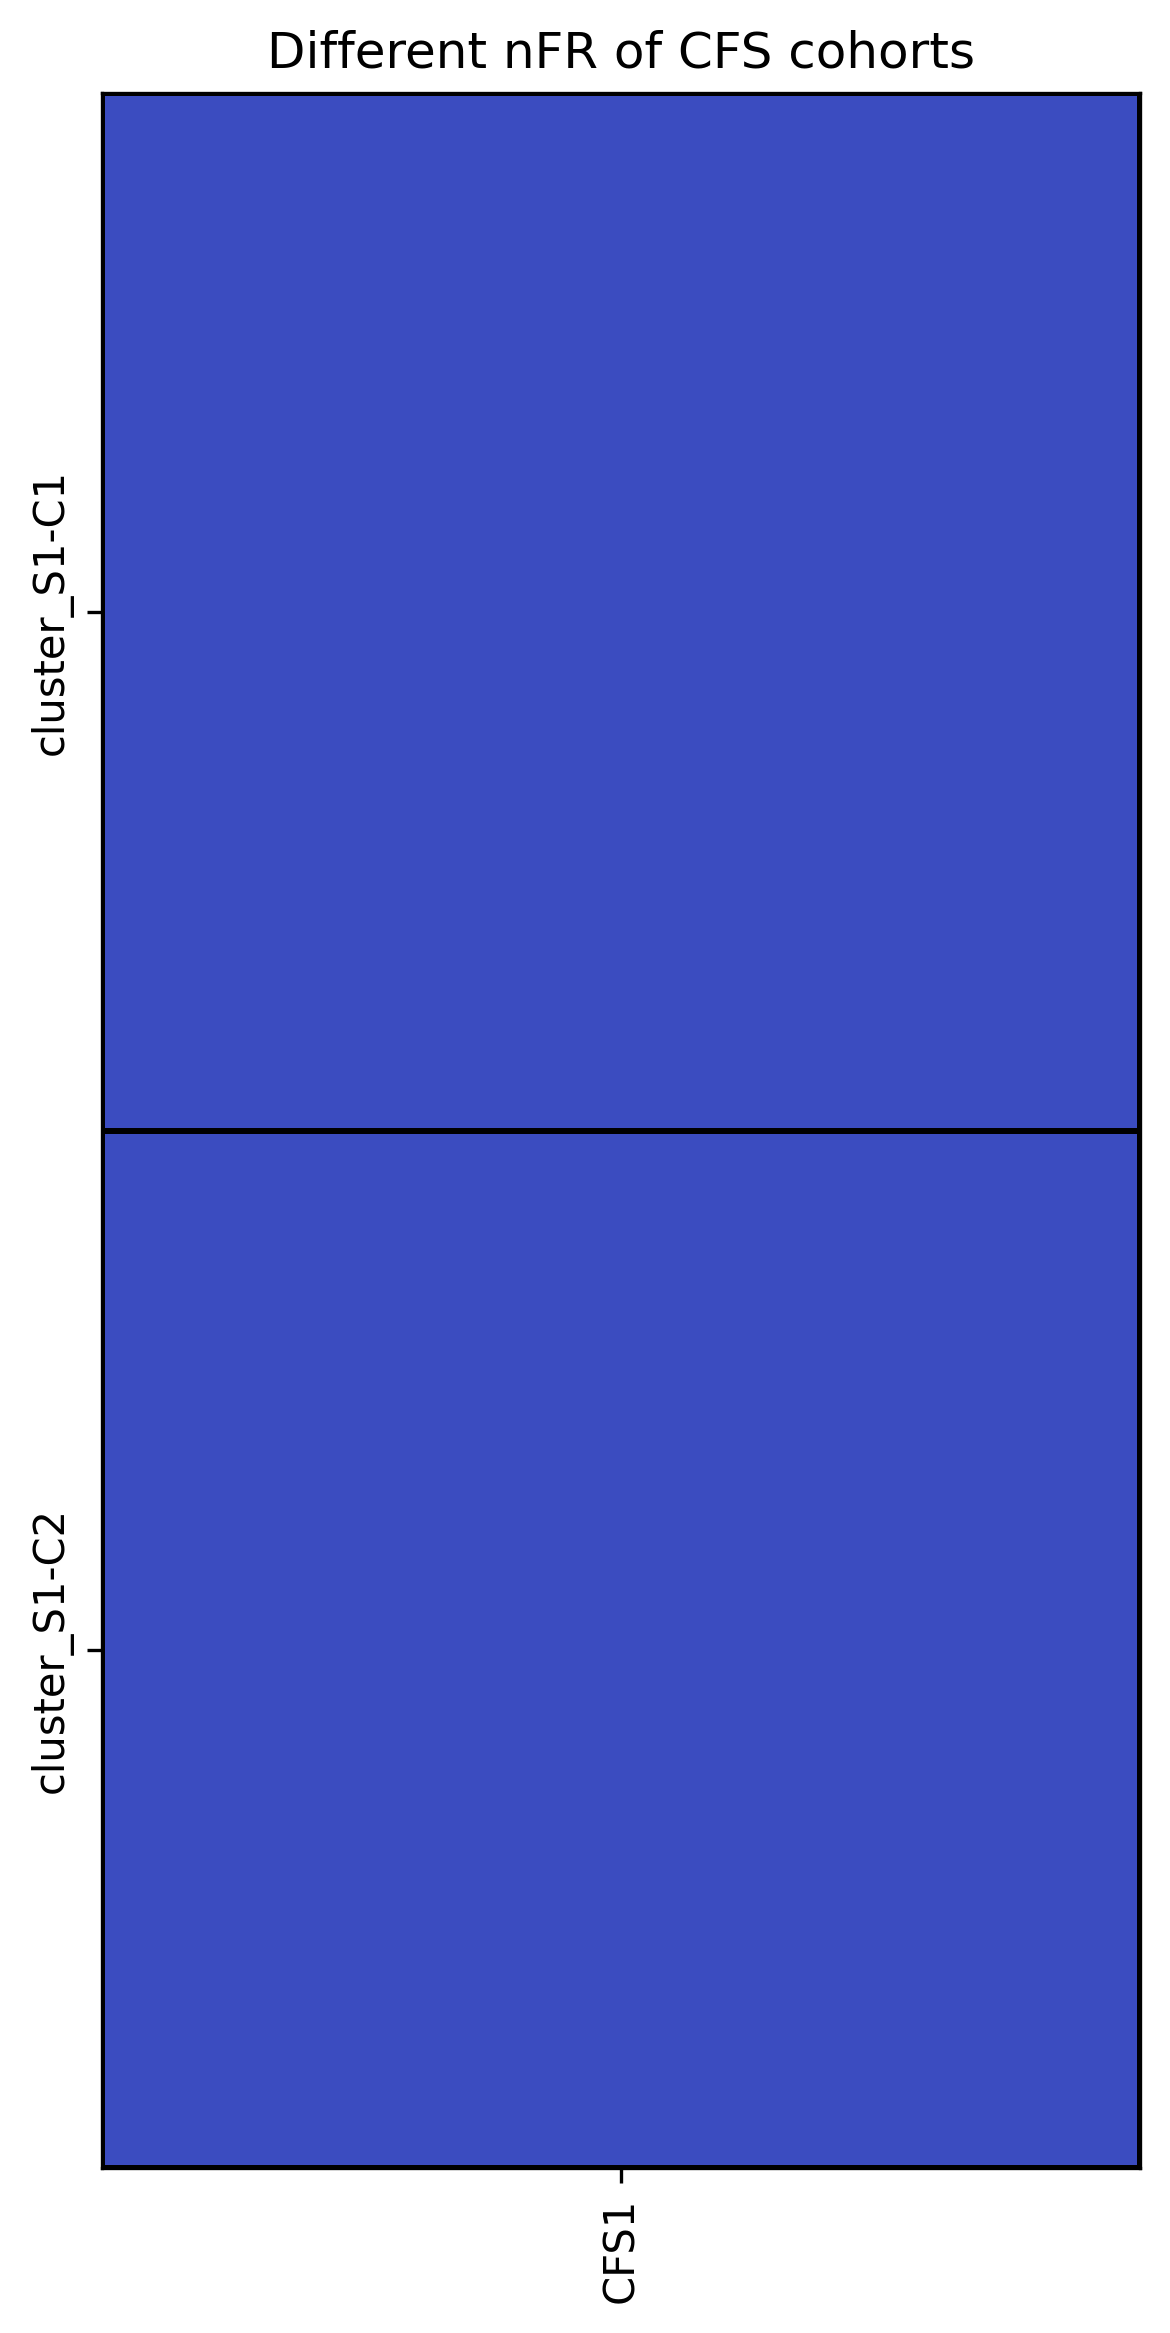

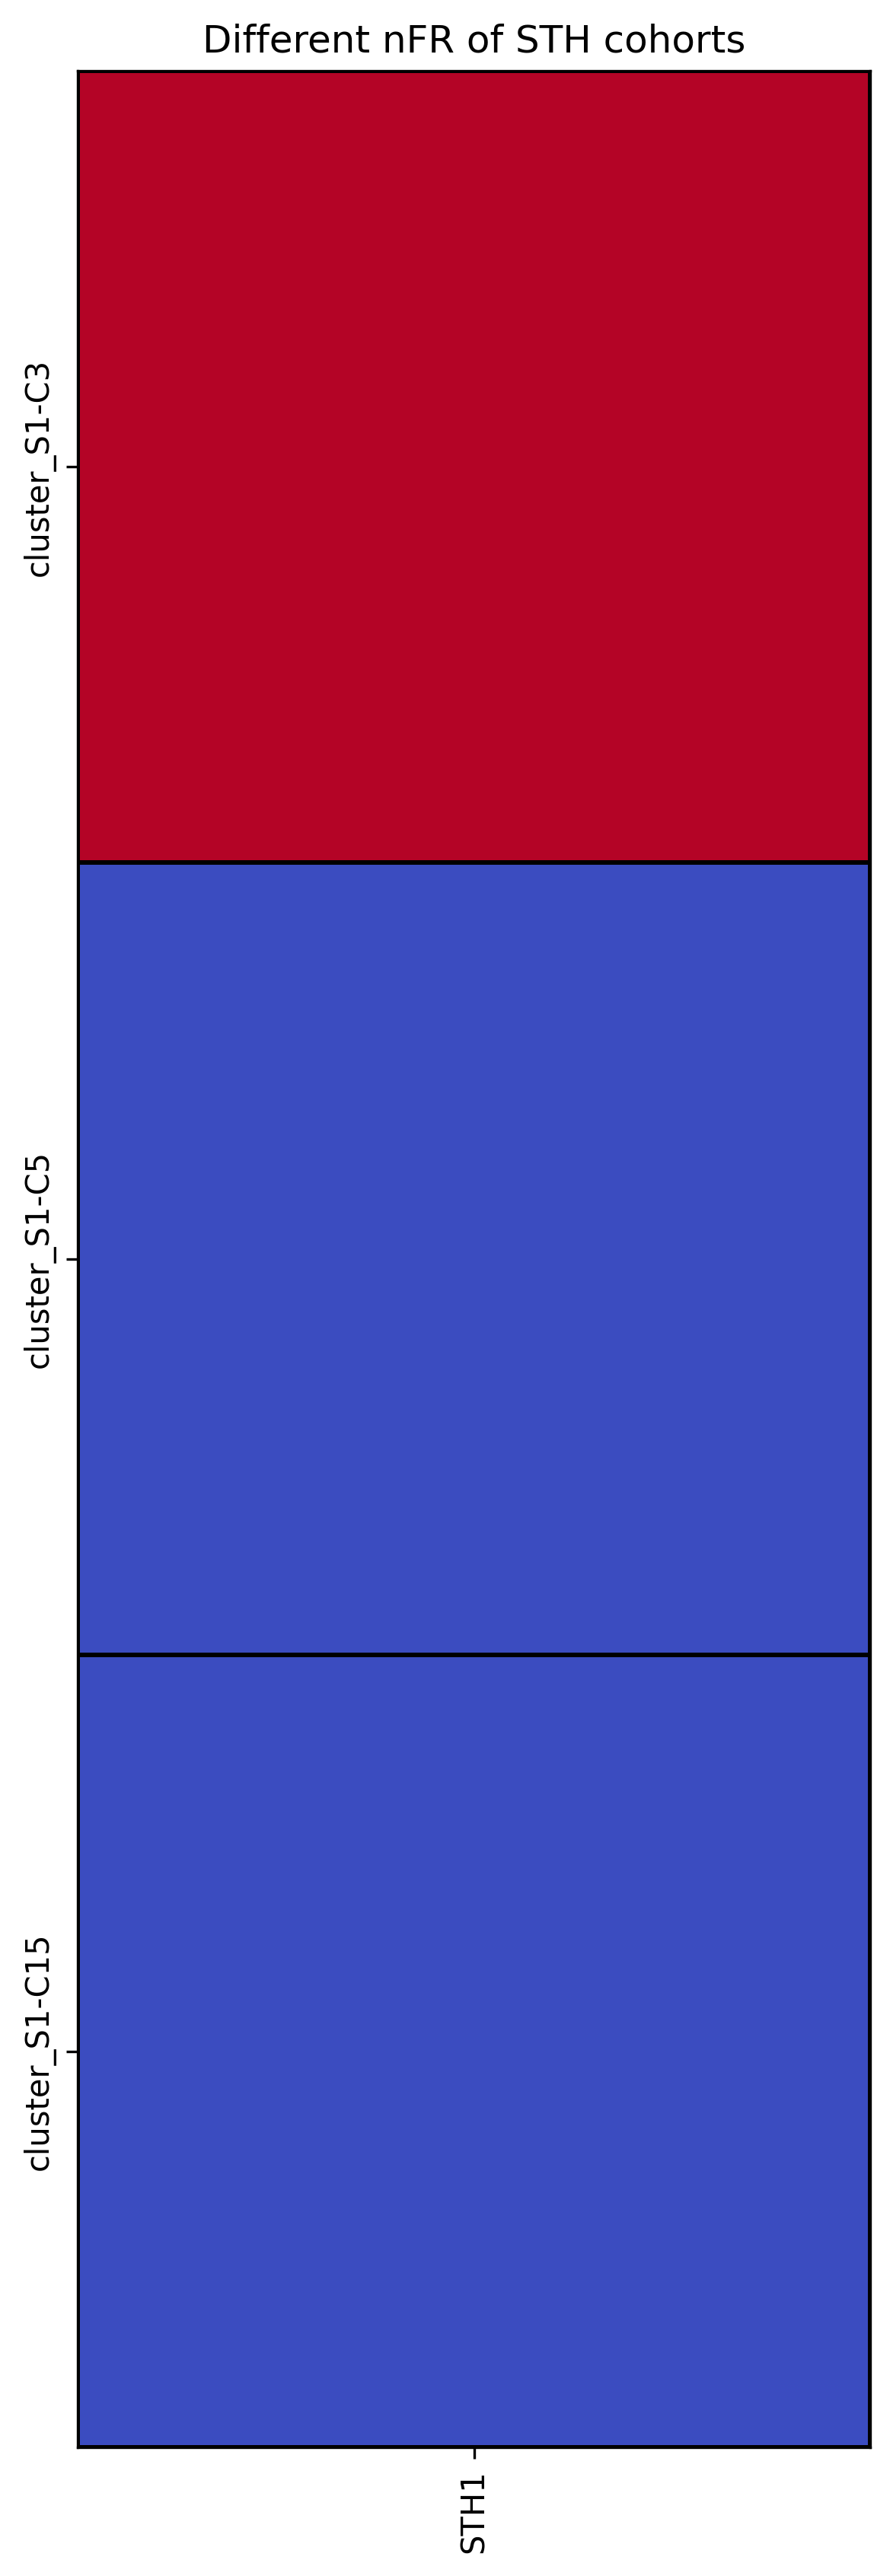

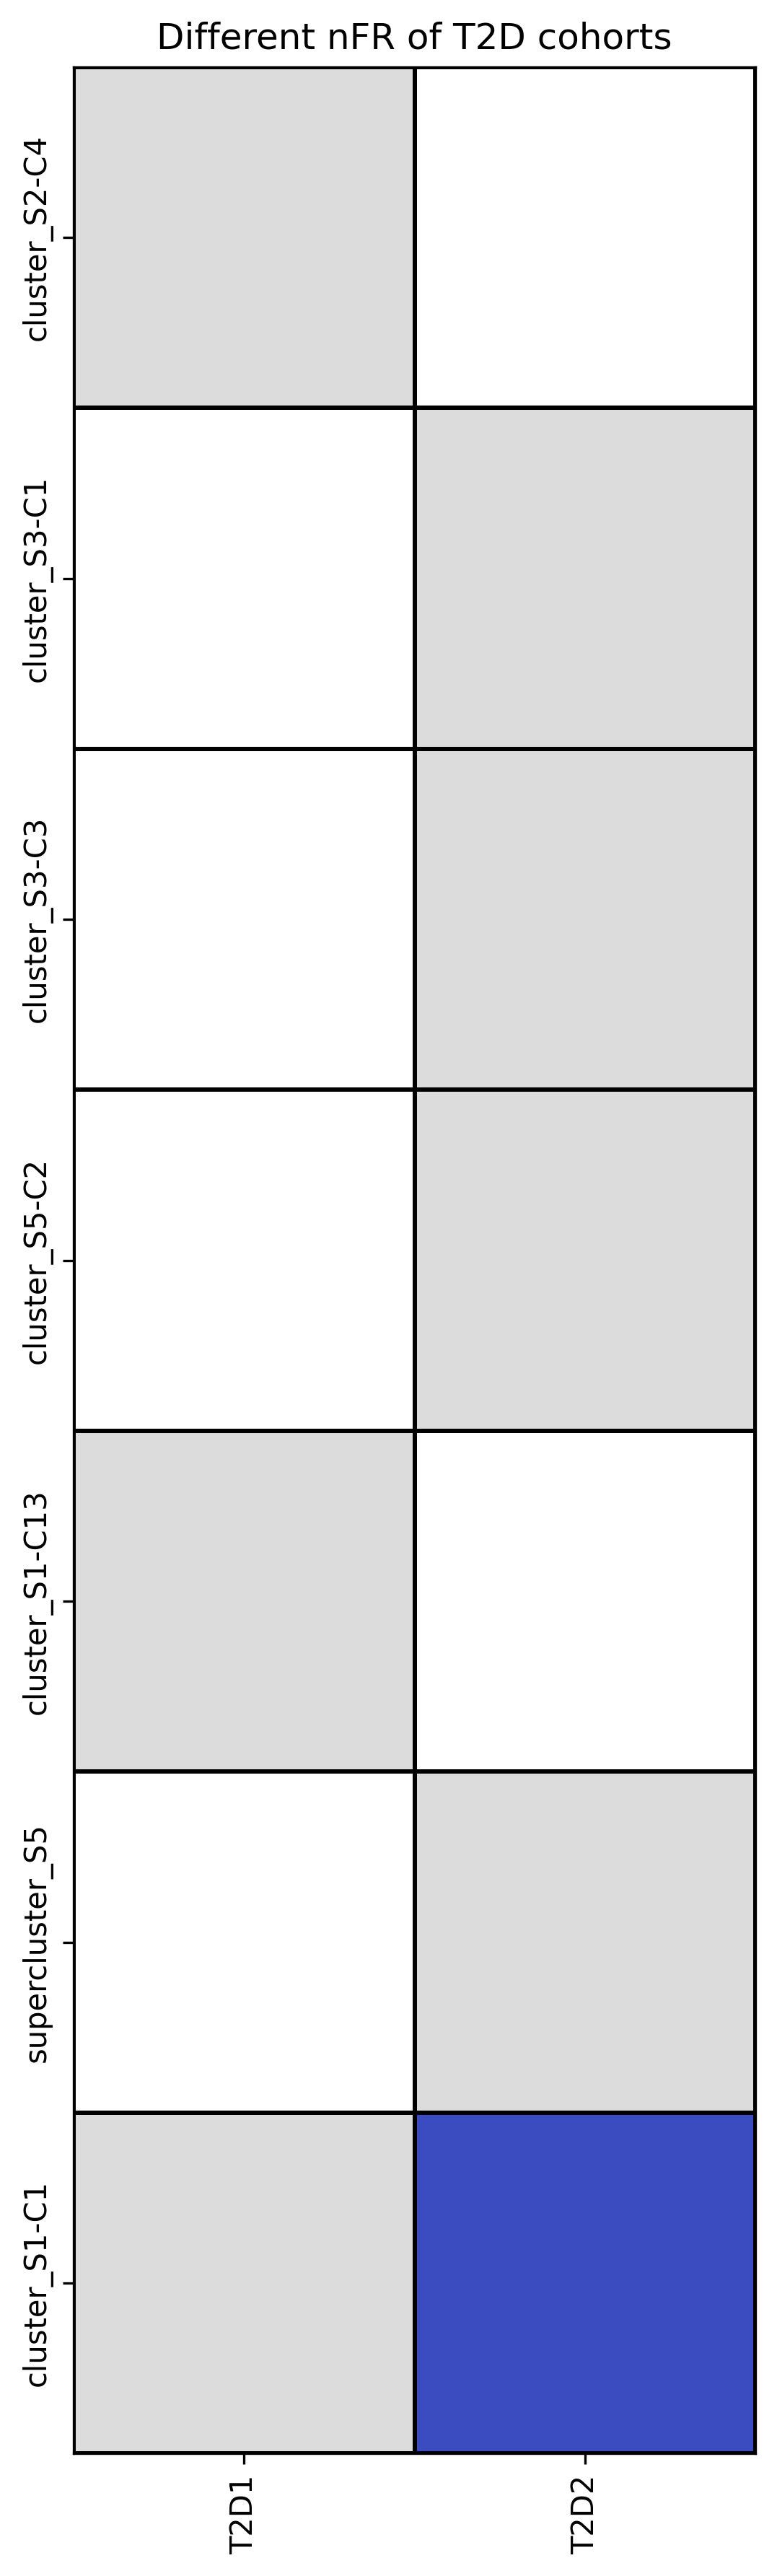

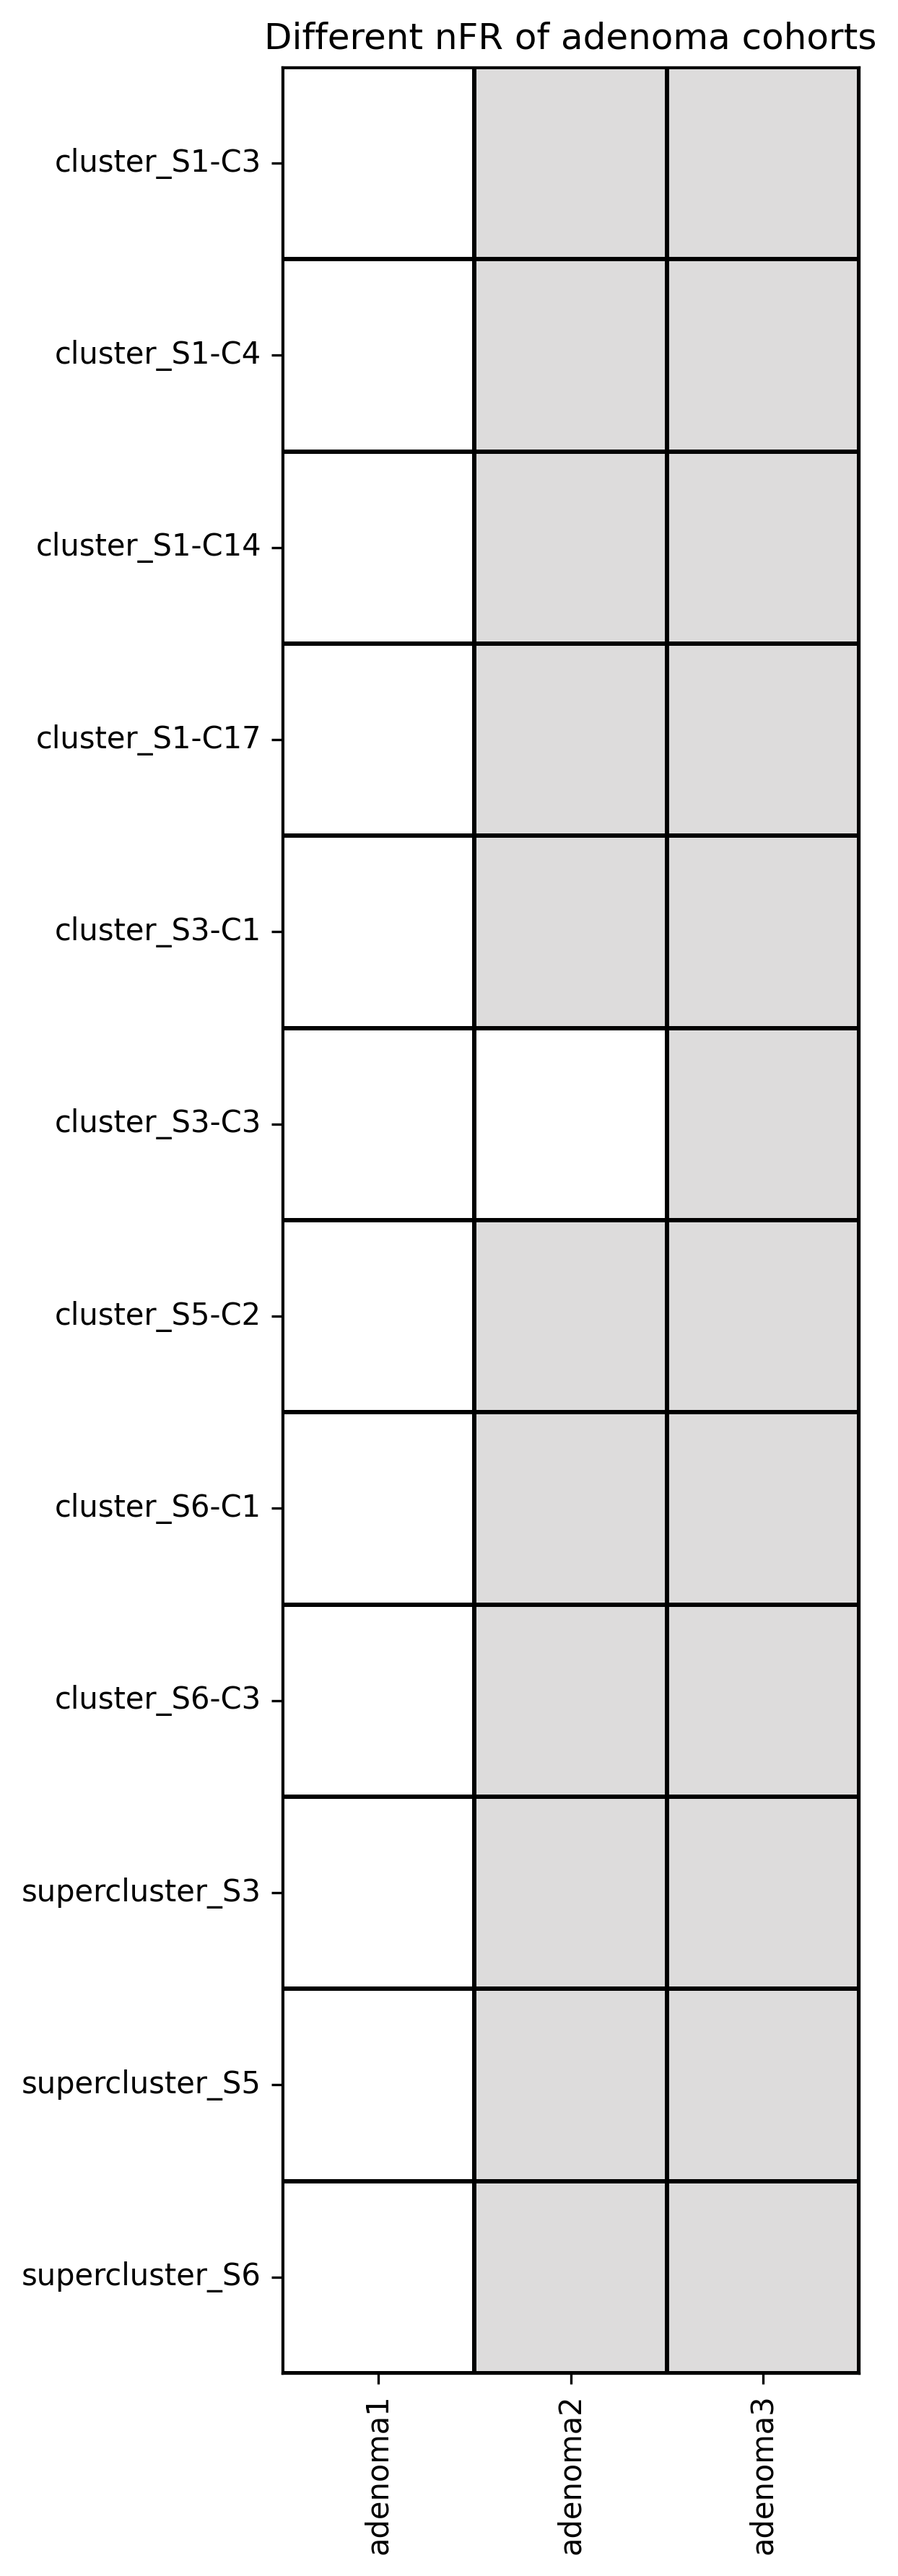

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


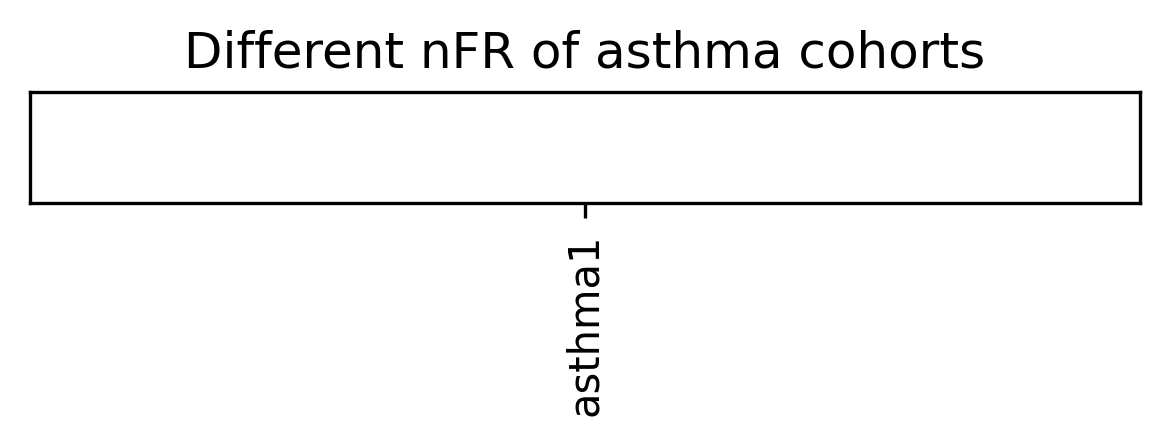

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


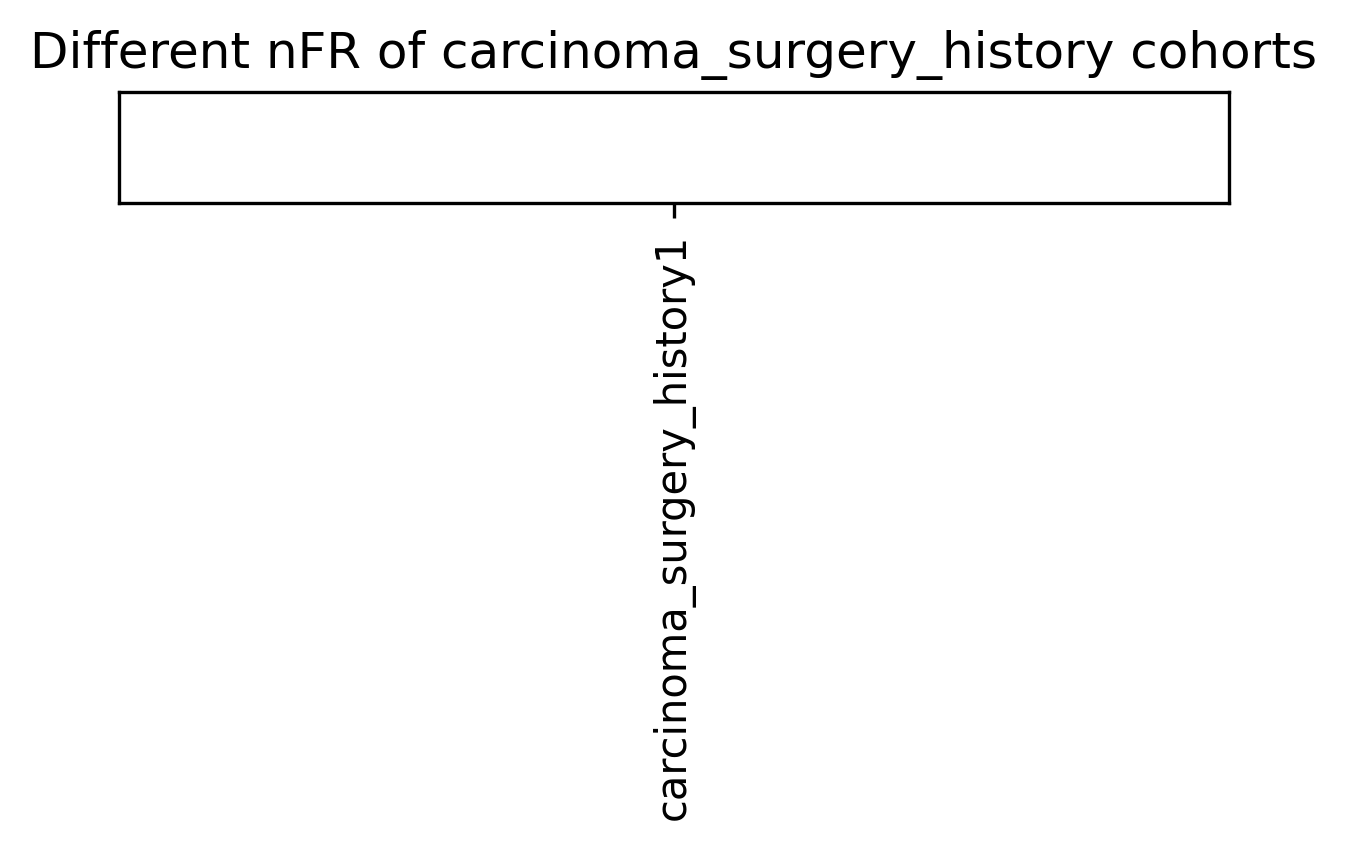

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


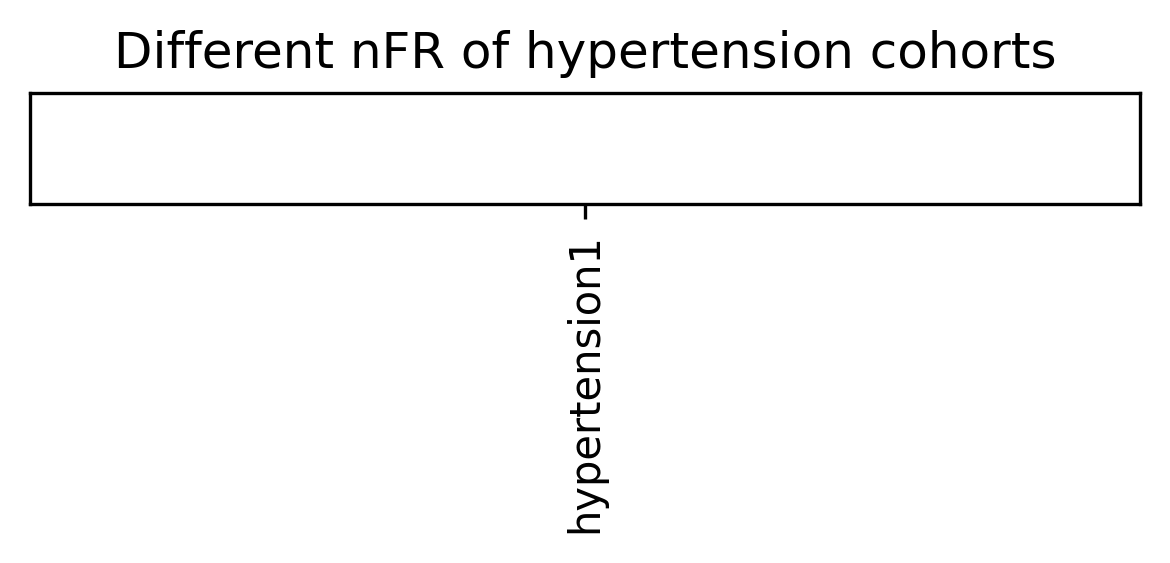

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


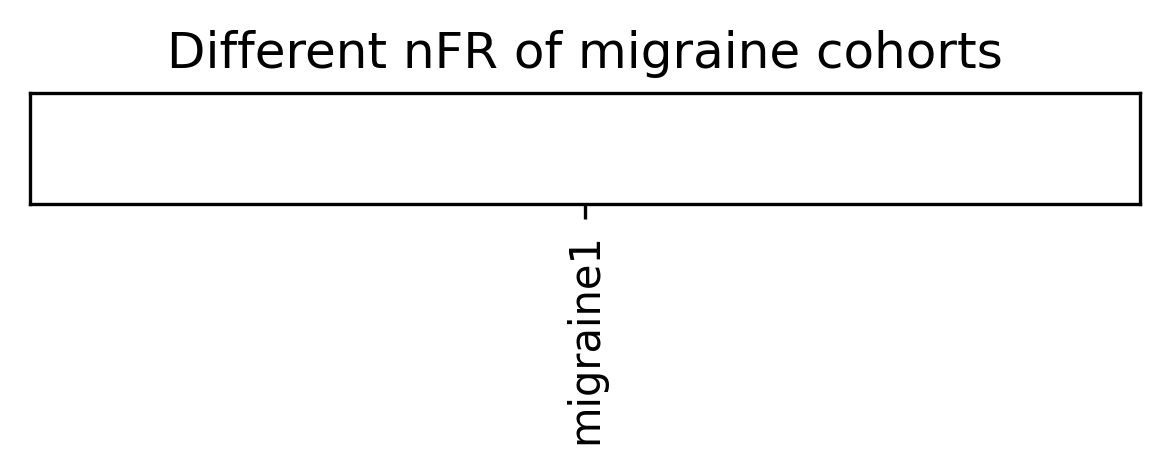

/home/chelijia/anaconda3/envs/meta_fr_r/lib/python3.8/site-packages/seaborn/matrix.py:309: UserWarning: Attempting to set identical low and high ylims makes transformation singular; automatically expanding.
  ax.set(xlim=(0, self.data.shape[1]), ylim=(0, self.data.shape[0]))


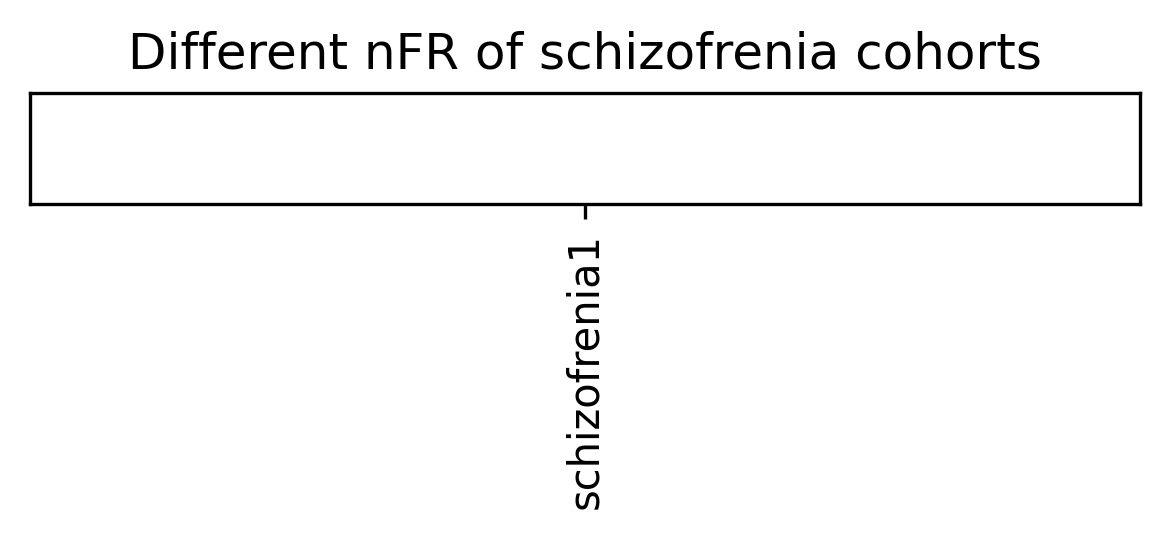

In [15]:
for disease in plist:   
    show_cohort = []
    show_node = []   
    for cohort in node_plot.index:
        if cohort.startswith(disease):
            show_cohort.append(cohort) 
    part_df = node_plot.loc[show_cohort, :]    
    for inode in part_df.columns:
        all_zero = True
        all_nan = True
        for dir in part_df.index:
            if not pd.isna(node_plot.loc[dir, inode]):
                all_nan = False
            if node_plot.loc[dir, inode] != 0:
                all_zero = False
        if not (all_zero or all_nan):
            show_node.append(inode)
    plt.figure(figsize=(4, 12))
    part_df = part_df[show_node]
    #print(part_df.astype(bool))
    non_zero_count = part_df.astype(bool).sum(axis=0) - part_df.isnull().sum(axis=0)
    #non_zero_count = part_df.sum(axis=0)
    #print(non_zero_count)
    sorted_df = part_df.iloc[:, non_zero_count.argsort()]
    # show_node = sorted(show_node)
    sns.heatmap(sorted_df.T, vmax=1, vmin=-1, square=True, linecolor='black', cbar=False, xticklabels=True, yticklabels=True, linewidths=1, cmap="coolwarm")
    plt.title('Different nFR of {} cohorts'.format(disease))
    plt.xticks(rotation=90)
    ax = plt.gca()

    ax.spines['top'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['left'].set_visible(True)
    ax.spines['right'].set_visible(True)
    odir = os.path.join(outdir, disease)
    if not os.path.exists(odir):
        os.makedirs(odir)
    opath = os.path.join(odir, '{}_nfr.pdf'.format(disease))
    plt.tight_layout()
    plt.savefig(opath, dpi=300, format='pdf')
    # part_df[show_node].to_csv(os.path.join(odir, '{}_nfr.tsv'.format(disease)), sep='\t')
    plt.show()
